In [11]:
import pandas as pd
# from tabulate import tabulate
import numpy as np
from pygobnilp.gobnilp import Gobnilp
# import bnlearn as bn
import pgmpy
import itertools
from scipy.stats import chi2_contingency #check for independence between 2 variables
from scipy.stats import power_divergence
from pgmpy.estimators.CITests import log_likelihood
from pgmpy.estimators.CITests import chi_square
# from pgmpy.factors.continuous.discretize import BaseDiscretizer

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

### chi-squared test

In [3]:
#how do we measure the consistensy
def chi2bool(df):
#returns a tuple(chi2, p_value, dof) if boolean = false
#the null hypothesis is that they are independent of each other
#if true, the p_value is higher than the significance test, we do not reject the null hypothesis
#if false, the p_value is lower than the significance test, we reject the null hypothesis
    v = list(df)
    empty = []
    empty_1 = []
    empty_2 = []
    empty_3 = []
    empty_4 = []
    itertools_combinations = list(itertools.combinations(v, 2)) #finds every possible combination of list(df)
    for i in itertools_combinations:
        empty_1.append(i[0])
        empty_2.append(i[1])
        
    total_number_of_combinations = len(empty_1)
    
    for t in range(len(itertools_combinations)):
        empty.append(itertools_combinations[t])
        
    for value in range(len(empty_1)):
        empty_3.append(value)
        
    for x,y,i,j in zip(empty_1, empty_2, empty, empty_3):
        chisquare = chi_square(X=x, Y=y, Z=[], data=df, significance_level=0.10, boolean=True) #returns chi, p_value, dof
        empty_4.append([j, i , chisquare])
        
    return empty_4

In [4]:
def chi2val(df):
#returns a tuple(chi2, p_value, dof) if boolean = false
#the null hypothesis is that they are independent of each other
#if true, the p_value is higher than the significance test, we do not reject the null hypothesis
#if false, the p_value is lower than the significance test, we reject the null hypothesis
    v = list(df)
    empty = []
    empty_1 = []
    empty_2 = []
    empty_3 = []
    empty_4 = []
    itertools_combinations = list(itertools.combinations(v, 2)) #finds every possible combination of list(df)
    for i in itertools_combinations:
        empty_1.append(i[0])
        empty_2.append(i[1])
        
    total_number_of_combinations = len(empty_1)
    
    for t in range(len(itertools_combinations)):
        empty.append(itertools_combinations[t])
        
    for value in range(len(empty_1)):
        empty_3.append(value)
        
    for x,y,i,j in zip(empty_1, empty_2, empty, empty_3):
        chisquare = chi_square(X=x, Y=y, Z=[], data=df, significance_level=0.05, boolean=False) #returns chi, p_value, dof
        empty_4.append([j, i , chisquare])
        
    return empty_4


In [41]:
#tests whether x is independent of y given a single variable z 
def chi2condbool(df):
    test_list_0 = []
    test_list_1 = []
    test_list_2 = []
    chi2 = []
    v = list(df)
    combine = list(itertools.combinations(v, 3)) #nC3 
    for i in combine:
        test_list_0.append(i[0])
        test_list_1.append(i[1])
        test_list_2.append(i[2])
    for a,b,c in zip(test_list_0, test_list_1, test_list_2):
        chisquare = chi_square(X=a, Y=b, Z=[c], data=df, significance_level=0.05, boolean=True)
        chi2.append([a,b,c,chisquare])
    return sortReturn(chi2)

In [6]:
#tests whether x is independent of y given a single variable z 
def chi2condval(df):
    test_list_0 = []
    test_list_1 = []
    test_list_2 = []
    chi2 = []
    v = list(df)
    combine = list(itertools.combinations(v, 3)) #nC3 
    for i in combine:
        test_list_0.append(i[0])
        test_list_1.append(i[1])
        test_list_2.append(i[2])
    for a,b,c in zip(test_list_0, test_list_1, test_list_2):
        chisquare = chi_square(X=a, Y=b, Z=[c], data=df, significance_level=0.05, boolean=False)
        chi2.append([a,b,c,chisquare])
    return chi2

### log-likelihood tests

In [7]:
def g2val(df):
#returns a tuple(chi2, p_value, dof) if boolean = false
#the null hypothesis is that they are independent of each other
#if true, the p_value is higher than the significance test, we do not reject the null hypothesis
#if false, the p_value is lower than the significance test, we reject the null hypothesis
    v = list(df)
    empty = []
    empty_1 = []
    empty_2 = []
    empty_3 = []
    empty_4 = []
    itertools_combinations = list(itertools.combinations(v, 2)) #finds every possible combination of list(df)
    for i in itertools_combinations:
        empty_1.append(i[0])
        empty_2.append(i[1])
        
    total_number_of_combinations = len(empty_1)
    
    for t in range(len(itertools_combinations)):
        empty.append(itertools_combinations[t])
        
    for value in range(len(empty_1)):
        empty_3.append(value)
        
    for x,y,i,j in zip(empty_1, empty_2, empty, empty_3):
        g2 = log_likelihood(X=x, Y=y, Z=[], significance_level=0.05, boolean=True, data=df) 
        empty_4.append([j, i , g2])
        
    return empty_4

### Sorting Functions

In [8]:
def sortReturn(data):
    #just a sorting function
    true_list = []
    false_list = []
    for i in data:
        if True in i:
            true_list.append(i)
        if False in i:
            false_list.append(i)
    return true_list, false_list

In [9]:
#returns a list with a tuple of combinations of false
def false2tuple(data):
    empty = []
    false_list_of_tuples = []
    new_df = pd.DataFrame(data)
    newer_df = new_df[1]
    return newer_df

In [68]:
def conditional(df):
    first_letter = []
    second_letter = []
    chi = chi2condbool(df) #returns unsorted list of true and false
    new_chi = chi[0]
    for i in new_chi:
        first_letter.append(i[0])
        second_letter.append(i[1])

In [38]:
var = conditional(df)

In [42]:
v = chi2condbool(df)

In [67]:
t = v[0]
t

[['One', 'Two', 'Four', True],
 ['One', 'Two', 'Five', True],
 ['One', 'Two', 'Six', True],
 ['One', 'Two', 'Ten', True],
 ['One', 'Two', 'Eleven', True],
 ['One', 'Two', 'Sixteen', True],
 ['One', 'Two', 'ThirtyTwo', True],
 ['One', 'Three', 'Four', True],
 ['One', 'Three', 'Seven', True],
 ['One', 'Three', 'Nine', True],
 ['One', 'Three', 'Twelve', True],
 ['One', 'Three', 'Thirteen', True],
 ['One', 'Three', 'Fourteen', True],
 ['One', 'Three', 'Fifteen', True],
 ['One', 'Three', 'Seventeen', True],
 ['One', 'Three', 'Eighteen', True],
 ['One', 'Three', 'Nineteen', True],
 ['One', 'Three', 'Twenty', True],
 ['One', 'Three', 'TwentyOne', True],
 ['One', 'Three', 'TwentyTwo', True],
 ['One', 'Three', 'TwentyThree', True],
 ['One', 'Three', 'TwentyFour', True],
 ['One', 'Three', 'TwentyFive', True],
 ['One', 'Three', 'TwentySix', True],
 ['One', 'Three', 'TwentySeven', True],
 ['One', 'Three', 'TwentyEight', True],
 ['One', 'Three', 'TwentyNine', True],
 ['One', 'Three', 'Thirty', True

In [63]:
for i in t:
    print(i[0], i[1])

One Two
One Two
One Two
One Two
One Two
One Two
One Two
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Three
One Four
One Four
One Four
One Four
One Four
One Five
One Five
One Five
One Five
One Five
One Five
One Five
One Five
One Five
One Five
One Six
One Six
One Six
One Six
One Six
One Six
One Six
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Seven
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One Eight
One

In [64]:
t

[['One', 'Two', 'Four', True],
 ['One', 'Two', 'Five', True],
 ['One', 'Two', 'Six', True],
 ['One', 'Two', 'Ten', True],
 ['One', 'Two', 'Eleven', True],
 ['One', 'Two', 'Sixteen', True],
 ['One', 'Two', 'ThirtyTwo', True],
 ['One', 'Three', 'Four', True],
 ['One', 'Three', 'Seven', True],
 ['One', 'Three', 'Nine', True],
 ['One', 'Three', 'Twelve', True],
 ['One', 'Three', 'Thirteen', True],
 ['One', 'Three', 'Fourteen', True],
 ['One', 'Three', 'Fifteen', True],
 ['One', 'Three', 'Seventeen', True],
 ['One', 'Three', 'Eighteen', True],
 ['One', 'Three', 'Nineteen', True],
 ['One', 'Three', 'Twenty', True],
 ['One', 'Three', 'TwentyOne', True],
 ['One', 'Three', 'TwentyTwo', True],
 ['One', 'Three', 'TwentyThree', True],
 ['One', 'Three', 'TwentyFour', True],
 ['One', 'Three', 'TwentyFive', True],
 ['One', 'Three', 'TwentySix', True],
 ['One', 'Three', 'TwentySeven', True],
 ['One', 'Three', 'TwentyEight', True],
 ['One', 'Three', 'TwentyNine', True],
 ['One', 'Three', 'Thirty', True

In [16]:
test_subject = conditional(df)

In [37]:
true_list = []
for i in test_subject:
    for j in i:
        if True in j:
            true_list.append(j)
true_list

[['One', 'Two', 'Four', True],
 ['One', 'Two', 'Five', True],
 ['One', 'Two', 'Six', True],
 ['One', 'Two', 'Ten', True],
 ['One', 'Two', 'Eleven', True],
 ['One', 'Two', 'Sixteen', True],
 ['One', 'Two', 'ThirtyTwo', True],
 ['One', 'Three', 'Four', True],
 ['One', 'Three', 'Seven', True],
 ['One', 'Three', 'Nine', True],
 ['One', 'Three', 'Twelve', True],
 ['One', 'Three', 'Thirteen', True],
 ['One', 'Three', 'Fourteen', True],
 ['One', 'Three', 'Fifteen', True],
 ['One', 'Three', 'Seventeen', True],
 ['One', 'Three', 'Eighteen', True],
 ['One', 'Three', 'Nineteen', True],
 ['One', 'Three', 'Twenty', True],
 ['One', 'Three', 'TwentyOne', True],
 ['One', 'Three', 'TwentyTwo', True],
 ['One', 'Three', 'TwentyThree', True],
 ['One', 'Three', 'TwentyFour', True],
 ['One', 'Three', 'TwentyFive', True],
 ['One', 'Three', 'TwentySix', True],
 ['One', 'Three', 'TwentySeven', True],
 ['One', 'Three', 'TwentyEight', True],
 ['One', 'Three', 'TwentyNine', True],
 ['One', 'Three', 'Thirty', True

In [30]:
for i in test_subject:
    for j in i:
        if True in j:
            print(j)

['One', 'Two', 'Four', True]
['One', 'Two', 'Five', True]
['One', 'Two', 'Six', True]
['One', 'Two', 'Ten', True]
['One', 'Two', 'Eleven', True]
['One', 'Two', 'Sixteen', True]
['One', 'Two', 'ThirtyTwo', True]
['One', 'Three', 'Four', True]
['One', 'Three', 'Seven', True]
['One', 'Three', 'Nine', True]
['One', 'Three', 'Twelve', True]
['One', 'Three', 'Thirteen', True]
['One', 'Three', 'Fourteen', True]
['One', 'Three', 'Fifteen', True]
['One', 'Three', 'Seventeen', True]
['One', 'Three', 'Eighteen', True]
['One', 'Three', 'Nineteen', True]
['One', 'Three', 'Twenty', True]
['One', 'Three', 'TwentyOne', True]
['One', 'Three', 'TwentyTwo', True]
['One', 'Three', 'TwentyThree', True]
['One', 'Three', 'TwentyFour', True]
['One', 'Three', 'TwentyFive', True]
['One', 'Three', 'TwentySix', True]
['One', 'Three', 'TwentySeven', True]
['One', 'Three', 'TwentyEight', True]
['One', 'Three', 'TwentyNine', True]
['One', 'Three', 'Thirty', True]
['One', 'Three', 'ThirtyOne', True]
['One', 'Three', 

In [12]:
df = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat")
df

,One,Two,Three,Four,Five,Six,Seven,Eight,Nine,Ten,...,TwentyEight,TwentyNine,Thirty,ThirtyOne,ThirtyTwo,ThirtyThree,ThirtyFour,ThirtyFive,ThirtySix,ThirtySeven
1,0,2,0,1,2,2,0,1,3,1,...,1,1,1,0,1,0,3,0,0,0
2,0,2,0,1,2,2,0,1,3,1,...,0,1,1,0,2,0,3,0,0,2
3,0,2,0,1,2,2,0,1,3,1,...,0,0,1,0,1,0,3,0,0,1
4,0,2,0,1,1,1,0,3,3,1,...,1,1,1,0,0,0,3,0,0,2
5,0,2,0,1,2,2,0,1,3,1,...,1,1,1,0,1,1,3,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,2,0,1,2,2,0,1,3,1,...,0,0,1,0,2,0,2,1,0,2
97,0,2,0,1,2,2,0,1,3,1,...,0,0,1,0,0,0,3,0,0,2
98,0,2,0,1,2,2,0,1,3,1,...,2,1,1,0,0,1,3,0,1,0
99,0,2,0,1,2,2,0,1,3,0,...,0,1,1,0,2,0,3,0,0,2


In [13]:
m = Gobnilp()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


**********
BN has score -1349.2274186560155
**********
Eight<-Six -48.02288071683779
Six<- -69.10334937651754
Eighteen<- -114.84864901676843
Eleven<-Four,Nine,One -44.97911452065159
Four<-One,Ten -21.730285019156838
Nine<-Eight -54.45803624535705
One<-Eight,Ten -4.268261513555785
Fifteen<- -37.18499768682693
Five<-Six,Thirteen,TwentyThree -20.200035333237963
TwentyThree<-Seventeen,ThirtySix,TwentySeven -48.97474871711532
Thirteen<-Eleven,TwentyOne,TwentyTwo -18.001271852931694
Ten<- -30.411803457824988
Fourteen<-Ten,Thirteen,TwentyFour -16.161465581650788
TwentyFour<-TwentyFive,TwentySeven -6.517130360384158
Nineteen<-Eighteen,One,Sixteen -17.5534622356339
Sixteen<-Eleven -29.91614912557563
Seven<-Eight,Six,TwentyEight -14.504697864948241
TwentyEight<-Twenty,TwentySeven -42.5552595253985
Seventeen<-Eighteen -17.0741477185569
TwentyTwo<-Three,Twenty -45.66257131044179
TwentyOne<-Nineteen,TwentyTwo -9.148246913140895
Thirty<-Nine,Sixteen -16.91092107259027
ThirtyFive<-TwentyFour -8.85415

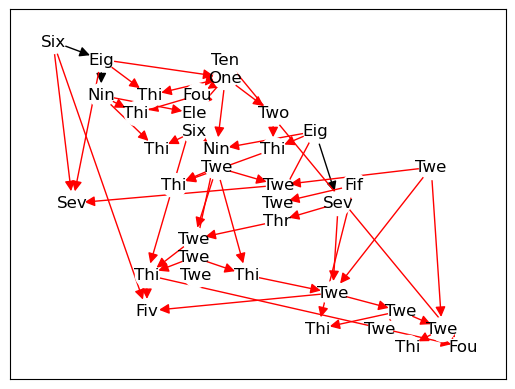

In [14]:
m.learn(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat")